In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.7.0+cu126
torchvision version: 0.22.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Create ResNet50 model definition
def create_resnet50_model(num_classes: int = 15,
                          seed: int = 42,
                          device = device):

    # Load default weights
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transform = weights.transforms()

    # Load pre-trained ResNet50 model
    model = torchvision.models.resnet50(weights=weights).to(device)

    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False

    # Set seeds (assumes you have a set_seeds() function already)
    set_seeds(seed)

    # Replace the classifier head
    model.fc = nn.Sequential(
        nn.Linear(in_features=2048, out_features=num_classes)
    ).to(device)

    return model, transform


In [ ]:
resnet50_animals, resnet50_transforms = create_resnet50_model(num_classes=15)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


In [ ]:
from torchinfo import summary

summary(resnet50_animals,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 15]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [ ]:
animal_train_transform = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    resnet50_transforms  # from create_resnet50_model
])

animal_train_transform


Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()

# Extract the uploaded ZIP file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("data")  # Extract to "data" folder

# Check extracted folder structure
os.listdir("data")


Saving animal_classification.zip to animal_classification.zip


['Animal Classification']

In [ ]:
import os
import shutil
import random
from pathlib import Path

# Original dataset path (with animal folders inside)
orig_data_path = Path("/content/data/Animal Classification/dataset")

# New split dataset path
split_data_path = Path("/content/data/Animal Classification/split_dataset")

# Train/test split ratio
train_ratio = 0.8

# Seed for reproducibility
random.seed(42)

# Create train and test directories
(train_dir := split_data_path / "train").mkdir(parents=True, exist_ok=True)
(test_dir := split_data_path / "test").mkdir(parents=True, exist_ok=True)

# Loop through each animal folder
for class_folder in orig_data_path.iterdir():
    if class_folder.is_dir():
        images = list(class_folder.glob("*"))  # all files inside class folder
        random.shuffle(images)

        train_count = int(len(images) * train_ratio)

        # Create class subfolders in train and test directories
        (train_class_dir := train_dir / class_folder.name).mkdir(parents=True, exist_ok=True)
        (test_class_dir := test_dir / class_folder.name).mkdir(parents=True, exist_ok=True)

        # Copy train images
        for img_path in images[:train_count]:
            shutil.copy(img_path, train_class_dir / img_path.name)

        # Copy test images
        for img_path in images[train_count:]:
            shutil.copy(img_path, test_class_dir / img_path.name)

        print(f"Class '{class_folder.name}': {train_count} train, {len(images) - train_count} test images copied.")


Class 'Dolphin': 103 train, 26 test images copied.
Class 'Bird': 109 train, 28 test images copied.
Class 'Tiger': 103 train, 26 test images copied.
Class 'Cow': 104 train, 27 test images copied.
Class 'Lion': 104 train, 27 test images copied.
Class 'Giraffe': 103 train, 26 test images copied.
Class 'Deer': 101 train, 26 test images copied.
Class 'Cat': 98 train, 25 test images copied.
Class 'Elephant': 106 train, 27 test images copied.
Class 'Dog': 97 train, 25 test images copied.
Class 'Kangaroo': 100 train, 26 test images copied.
Class 'Panda': 108 train, 27 test images copied.
Class 'Horse': 104 train, 26 test images copied.
Class 'Bear': 100 train, 25 test images copied.
Class 'Zebra': 109 train, 28 test images copied.


In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(split_data_path / "train", transform=animal_train_transform)
test_data = datasets.ImageFolder(split_data_path / "test", transform=resnet50_transforms)


In [ ]:
class_names_animals = train_data.classes
print(len(class_names_animals), class_names_animals[:5])


15 ['Bear', 'Bird', 'Cat', 'Cow', 'Deer']


In [ ]:
# Creating DataLoaders
import os

BATCH_SIZE = 32
NUM_WORKERS=os.cpu_count()

train_dataloader_animals = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_animals = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(len(train_dataloader_animals), len(test_dataloader_animals))


49 13


In [ ]:
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(params=resnet50_animals.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()  # make sure your seed function is defined

resnet50_results = engine.train(
    model=resnet50_animals,
    train_dataloader=train_dataloader_animals,
    test_dataloader=test_dataloader_animals,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6911 | train_acc: 0.9879 | test_loss: 0.6483 | test_acc: 0.9928
Epoch: 2 | train_loss: 0.6896 | train_acc: 0.9844 | test_loss: 0.6420 | test_acc: 0.9952
Epoch: 3 | train_loss: 0.6842 | train_acc: 0.9787 | test_loss: 0.6404 | test_acc: 0.9952
Epoch: 4 | train_loss: 0.6853 | train_acc: 0.9816 | test_loss: 0.6358 | test_acc: 0.9952
Epoch: 5 | train_loss: 0.6671 | train_acc: 0.9850 | test_loss: 0.6390 | test_acc: 0.9928
Epoch: 6 | train_loss: 0.6680 | train_acc: 0.9879 | test_loss: 0.6292 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.6792 | train_acc: 0.9802 | test_loss: 0.6270 | test_acc: 0.9976
Epoch: 8 | train_loss: 0.6747 | train_acc: 0.9838 | test_loss: 0.6278 | test_acc: 0.9952
Epoch: 9 | train_loss: 0.6645 | train_acc: 0.9847 | test_loss: 0.6251 | test_acc: 0.9952
Epoch: 10 | train_loss: 0.6551 | train_acc: 0.9923 | test_loss: 0.6235 | test_acc: 0.9976


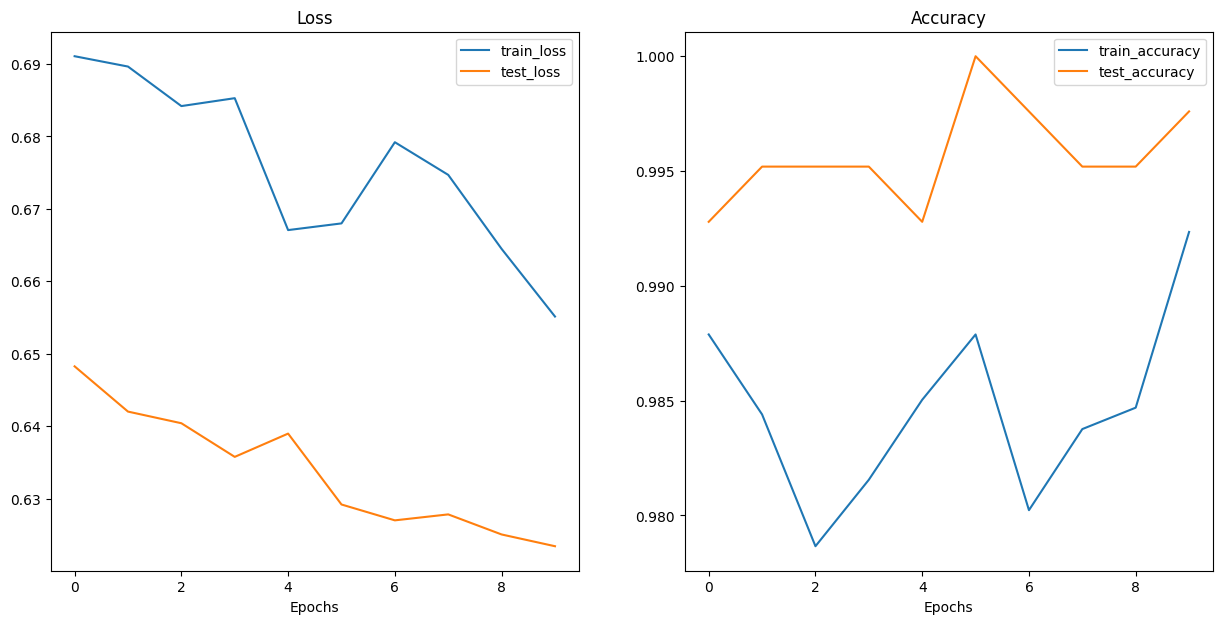

In [ ]:
# Losscurvers
plot_loss_curves(resnet50_results)

In [ ]:
from going_modular.going_modular import utils
Animal_Resnet50_model_path = "Animal_Resnet50.pth"
utils.save_model(model=resnet50_animals,
                 target_dir="models/",
                 model_name=Animal_Resnet50_model_path)

[INFO] Saving model to: models/Animal_Resnet50.pth


In [ ]:
# Create instance of the ResNet50 model for Animal classification
loaded_resnet50_animals, _ = create_resnet50_model(num_classes=15)

# Load the saved model weights
loaded_resnet50_animals.load_state_dict(torch.load("models/Animal_Resnet50.pth"))

# Set the model to evaluation mode before inference
loaded_resnet50_animals.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_Animal_Resnet50_model_size = Path("models", Animal_Resnet50_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained Resnet50 feature extractor Animal model size: {pretrained_Animal_Resnet50_model_size} MB")

Pretrained Resnet50 feature extractor Animal model size: 90 MB


In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00
Gradio version: 5.32.0


In [ ]:
from pathlib import Path

# Create AnimalVision ResNet50 demo path
animalvision_resnet50_demo_path = Path("demos/animalvision_resnet50/")

# Make AnimalVision ResNet50 demo directory
animalvision_resnet50_demo_path.mkdir(parents=True, exist_ok=True)

# Make examples directory for demo
(animalvision_resnet50_demo_path / "examples").mkdir(parents=True, exist_ok=True)


In [ ]:
import shutil
from pathlib import Path

# List of real image paths from your 15 animal classes
animalvision_examples = [
    Path("/content/data/Animal Classification/dataset/Bird/Bird_10.jpeg"),
    Path("/content/data/Animal Classification/dataset/Bear/Bear_10_3.jpg"),
    Path("/content/data/Animal Classification/dataset/Cat/Cat_10_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Cow/Cow_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Deer/Deer_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Dog/Dog_10.jpg"),
    Path("/content/data/Animal Classification/dataset/Dolphin/Dolphin_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Elephant/Elephant_10.jpg"),
    Path("/content/data/Animal Classification/dataset/Giraffe/Giraffe_10.jpeg"),
    Path("/content/data/Animal Classification/dataset/Horse/Horse_1.jpeg"),
    Path("/content/data/Animal Classification/dataset/Kangaroo/Kangaroo_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Lion/Lion_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Panda/Panda_1.jpeg"),
    Path("/content/data/Animal Classification/dataset/Tiger/Tiger_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Zebra/Zebra_1.jpg")
]

def copy_images_to_examples(src_paths, dest_dir):
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)  # Ensure destination directory exists

    for src_path in src_paths:
        if src_path.exists():
            shutil.copy(src_path, dest_dir / src_path.name)
            print(f"✅ Copied {src_path.name} to {dest_dir}")
        else:
            print(f"❌ Source image not found: {src_path}")

# Run the function to copy into your demo folder
copy_images_to_examples(
    animalvision_examples,
    "/content/demos/animalvision_resnet50/examples"
)


✅ Copied Bird_10.jpeg to /content/demos/animalvision_resnet50/examples
✅ Copied Bear_10_3.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Cat_10_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Cow_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Deer_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Dog_10.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Dolphin_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Elephant_10.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Giraffe_10.jpeg to /content/demos/animalvision_resnet50/examples
✅ Copied Horse_1.jpeg to /content/demos/animalvision_resnet50/examples
✅ Copied Kangaroo_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Lion_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copied Panda_1.jpeg to /content/demos/animalvision_resnet50/examples
✅ Copied Tiger_1.jpg to /content/demos/animalvision_resnet50/examples
✅ Copi

In [ ]:
# Move trained Animal ResNet50 model to AnimalVision demo folder (only if not already moved)
!mv models/Animal_Resnet50.pth demos/animalvision_resnet50


In [ ]:
# Check out the first 10 Animal class names
class_names_animals = train_data.classes
len(class_names_animals)
class_names_animals


['Bear',
 'Bird',
 'Cat',
 'Cow',
 'Deer',
 'Dog',
 'Dolphin',
 'Elephant',
 'Giraffe',
 'Horse',
 'Kangaroo',
 'Lion',
 'Panda',
 'Tiger',
 'Zebra']

In [ ]:
# Create path to Animal class names
animal_class_names_path = animalvision_resnet50_demo_path / "animal_class_names.txt"

# Write Animal class names list to file
with open(animal_class_names_path, "w") as f:
    print(f"[INFO] Saving Animal class names to {animal_class_names_path}")
    f.write("\n".join(class_names_animals))  # leave a new line between each class


[INFO] Saving Animal class names to demos/animalvision_resnet50/animal_class_names.txt


In [ ]:
# Open Animal class names file and read each line into a list
with open(animal_class_names_path, "r") as f:
    animal_class_names_loaded = [line.strip() for line in f.readlines()]

# View the first 5 class names loaded back in
animal_class_names_loaded[:5]


['Bear', 'Bird', 'Cat', 'Cow', 'Deer']

In [ ]:
%%writefile /content/demos/animalvision_resnet50/model.py

import torch
import torchvision

from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# Create ResNet50 model definition
def create_resnet50_model(num_classes: int = 15,
                          seed: int = 42,
                          device = device):

    # Load default weights
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transform = weights.transforms()

    # Load pre-trained ResNet50 model
    model = torchvision.models.resnet50(weights=weights).to(device)

    # Freeze base layers
    for param in model.parameters():
        param.requires_grad = False

    # Set seeds (assumes you have a set_seeds() function already)
    set_seeds(seed)

    # Replace the classifier head
    model.fc = nn.Sequential(
        nn.Linear(in_features=2048, out_features=num_classes)
    ).to(device)

    return model, transform

Writing /content/demos/animalvision_resnet50/model.py


In [ ]:
import random
from pathlib import Path

# List all animal image paths (your given full paths)
animal_image_paths = [
    Path("/content/data/Animal Classification/dataset/Bird/Bird_10.jpeg"),
    Path("/content/data/Animal Classification/dataset/Bear/Bear_10_3.jpg"),
    Path("/content/data/Animal Classification/dataset/Cat/Cat_10_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Cow/Cow_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Deer/Deer_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Dog/Dog_10.jpg"),
    Path("/content/data/Animal Classification/dataset/Dolphin/Dolphin_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Elephant/Elephant_10.jpg"),
    Path("/content/data/Animal Classification/dataset/Giraffe/Giraffe_10.jpeg"),
    Path("/content/data/Animal Classification/dataset/Horse/Horse_1.jpeg"),
    Path("/content/data/Animal Classification/dataset/Kangaroo/Kangaroo_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Lion/Lion_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Panda/Panda_1.jpeg"),
    Path("/content/data/Animal Classification/dataset/Tiger/Tiger_1.jpg"),
    Path("/content/data/Animal Classification/dataset/Zebra/Zebra_1.jpg"),
]

# Pick 3 random images and wrap paths as string in their own list
example_list = [[str(path)] for path in random.sample(animal_image_paths, k=3)]

print(example_list)


[['/content/data/Animal Classification/dataset/Deer/Deer_1.jpg'], ['/content/data/Animal Classification/dataset/Bear/Bear_10_3.jpg'], ['/content/data/Animal Classification/dataset/Panda/Panda_1.jpeg']]


In [ ]:
import shutil
from pathlib import Path

# List of your Animal Classification image paths
animal_examples = [
    Path('/content/data/Animal Classification/dataset/Bird/Bird_10.jpeg'),
    Path('/content/data/Animal Classification/dataset/Bear/Bear_10_3.jpg'),
    Path('/content/data/Animal Classification/dataset/Cat/Cat_10_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Cow/Cow_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Deer/Deer_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Dog/Dog_10.jpg'),
    Path('/content/data/Animal Classification/dataset/Dolphin/Dolphin_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Elephant/Elephant_10.jpg'),
    Path('/content/data/Animal Classification/dataset/Giraffe/Giraffe_10.jpeg'),
    Path('/content/data/Animal Classification/dataset/Horse/Horse_1.jpeg'),
    Path('/content/data/Animal Classification/dataset/Kangaroo/Kangaroo_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Lion/Lion_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Panda/Panda_1.jpeg'),
    Path('/content/data/Animal Classification/dataset/Tiger/Tiger_1.jpg'),
    Path('/content/data/Animal Classification/dataset/Zebra/Zebra_1.jpg'),
]

def copy_images_to_examples(src_paths, dest_dir):
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)  # Ensure destination directory exists

    for src_path in src_paths:
        if src_path.exists():
            shutil.copy(src_path, dest_dir / src_path.name)
            print(f"Copied {src_path} to {dest_dir / src_path.name}")
        else:
            print(f"Source image not found: {src_path}")

# Run the function to copy animal images to your demo examples folder
copy_images_to_examples(animal_examples, "/content/demos/animalvision_resnet50/examples")


Copied /content/data/Animal Classification/dataset/Bird/Bird_10.jpeg to /content/demos/animalvision_resnet50/examples/Bird_10.jpeg
Copied /content/data/Animal Classification/dataset/Bear/Bear_10_3.jpg to /content/demos/animalvision_resnet50/examples/Bear_10_3.jpg
Copied /content/data/Animal Classification/dataset/Cat/Cat_10_1.jpg to /content/demos/animalvision_resnet50/examples/Cat_10_1.jpg
Copied /content/data/Animal Classification/dataset/Cow/Cow_1.jpg to /content/demos/animalvision_resnet50/examples/Cow_1.jpg
Copied /content/data/Animal Classification/dataset/Deer/Deer_1.jpg to /content/demos/animalvision_resnet50/examples/Deer_1.jpg
Copied /content/data/Animal Classification/dataset/Dog/Dog_10.jpg to /content/demos/animalvision_resnet50/examples/Dog_10.jpg
Copied /content/data/Animal Classification/dataset/Dolphin/Dolphin_1.jpg to /content/demos/animalvision_resnet50/examples/Dolphin_1.jpg
Copied /content/data/Animal Classification/dataset/Elephant/Elephant_10.jpg to /content/demos

In [ ]:
%%writefile /content/demos/animalvision_resnet50/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_resnet50_model  # changed to your ResNet50 model creator
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:  # reading them in from class_names.txt
    class_names = [animal_name.strip() for animal_name in f.readlines()]

### 2. Model and transforms preparation ###

# Create model instance with number of classes matching your dataset (15 animals)
resnet50_animals, resnet50_transforms = create_resnet50_model(
    num_classes=15,  # update according to your animal classes
)

# Load saved weights for your Animal ResNet50 model
resnet50_animals.load_state_dict(
    torch.load(
        f="Animal_Resnet50.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken."""
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = resnet50_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    resnet50_animals.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into probabilities
        pred_probs = torch.softmax(resnet50_animals(img), dim=1)

    # Create prediction dictionary for Gradio Label output
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Animal Classification ResNet50 🐾"
description = "A ResNet50 computer vision model trained to classify images into 15 different animal classes."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description
)

# Launch the app!
demo.launch()


Writing /content/demos/animalvision_resnet50/app.py


In [ ]:
%%writefile /content/demos/animalvision_resnet50/requirements.txt
torch
torchvision
gradio

Writing /content/demos/animalvision_resnet50/requirements.txt


In [ ]:
from google.colab import files
import os

# Create zip from inside the folder, place zip in /content directly for easy access
!cd /content/demos/animalvision_resnet50 && zip -r /content/Animal_Resnet50.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Check if file exists where expected
print("Zip file exists:", os.path.exists("/content/Animal_Resnet50.zip"))

# Download the file from /content
files.download("/content/Animal_Resnet50.zip")


  adding: animal_class_names.txt (deflated 11%)
  adding: Animal_Resnet50.pth (deflated 7%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/Bird_10.jpeg (deflated 1%)
  adding: examples/Bear_10_3.jpg (deflated 1%)
  adding: examples/Cat_10_1.jpg (deflated 1%)
  adding: examples/Giraffe_10.jpeg (deflated 1%)
  adding: examples/Horse_1.jpeg (deflated 1%)
  adding: examples/Deer_1.jpg (deflated 0%)
  adding: examples/Kangaroo_1.jpg (deflated 7%)
  adding: examples/Elephant_10.jpg (deflated 1%)
  adding: examples/Tiger_1.jpg (deflated 1%)
  adding: examples/Lion_1.jpg (deflated 1%)
  adding: examples/Zebra_1.jpg (deflated 4%)
  adding: examples/Cow_1.jpg (deflated 3%)
  adding: examples/Panda_1.jpeg (deflated 1%)
  adding: examples/Dog_10.jpg (deflated 3%)
  adding: examples/Dolphin_1.jpg (deflated 1%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 4%)
Zip file exists: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>